# **WARNING**

In order for this notebook to run, you must first run the notebook `1_0_generate_noturn_data.ipynb` and generate the file `result/singlegame_results/player10_noturn_results.csv` which contains the optimal policy and value functions for the solved MDPs for different player skill model and epsilon combinatinos. It is also important to make sure that all combinations you want to analyse in this file were generated during this process. 

# 1.0 Notebook Parameters

Please specify the following variables:
1. `project_directory`: your project directory path
2. `epsilon_list`: the list of execution error multiplers (epsilon) that you want to consider in your analysis.
3. `player_id`: the players (i.e. skill model) you want to consider in your analysis; use one base model and scale it with different epsilons; this should match whatever was used in `1_0_generate_noturn_data.ipynb`.
4. `Iterations`: the number of iterations that should be used for each simulation run. 

In [1]:
# Change this to the project directory path for your computer  
project_directory = '/Users/rachael/Desktop/darts-thesis'
project_directory = '/Users/Craig/PycharmProjects/darts-thesis'
project_directory = '/Users/rachael/Desktop/test/darts-thesis'

# Set the epsilons that will be considered in this analysis 
epsilon_list = [1,2,3,4,5,6,7,8,9]

# Set the ID of the player skill models you want to use 
    # 10 - symmetric DB skill model that we were using up until now 
    # "AVG" - "average pro" skill model generated by H & W 
player_id = 'AVG'
#player_id = 10

# Set the number of iterations you want to use in your simulations
default_iterations = 10000


# 2.0 Notebook Setup

In [2]:
# Import and configure modules from this project

import os

os.chdir(project_directory)

from class_simulator_noturn import Simulator

import class_handicap as hc 
handicap = hc.Handicap(results_file_name='./result/singlegame_results/playerAVG_noturn_results.csv', epsilon_list = epsilon_list)

# import function_init_baoard as fb
# import function_init_simple_mdp as imdp

/Users/rachael/miniconda3/envs/darts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import external libraries

import time 

import pandas as pd

import numpy as np

import statistics


# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in divide")
warnings.filterwarnings("ignore", message="overflow encountered in divide")


In [4]:
# Helper functions 

def build_dataset(simulation_paths,player_num,epsilon,tokens):
    data_list = []
    data_cols = ['player','epsilon','tokens','game_id','throw_number','state','state_score','state_tokens']

    for game in range(len(simulation_paths)):

        for throw in range(len(simulation_paths[game])):

            data_list.append([player_num,epsilon,tokens,game,throw,simulation_paths[game][throw],simulation_paths[game][throw][0],simulation_paths[game][throw][1]])

    df = pd.DataFrame(data_list,columns=data_cols)

    return df 


def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = colors.rgb2hex(rgb)
    return color

# 3.0 Sanity Check Sandbox

Validate the simlator by checkinng that the expected game outcome matches the solution of our MDP model.

In [5]:
#Sanity Check - V(501) for e=1 and t=0 should be ~15.85 for default player number of 10 

#################### PARAMETERS #########################
# Can override the defaults above if desired
iterations = default_iterations

# Set player information 
player_num = player_id
epsilon = 1

# Set the starting state of the game 
starting_score = 501
starting_credits = 0

#########################################################

sim = Simulator(player_num, epsilon)
simulation_paths = sim.run_simulation(iterations,starting_score=starting_score,starting_credits=starting_credits)
df_sanity_check = build_dataset(simulation_paths,player_num,epsilon,starting_credits)


df_sanity_check.groupby('game_id').count().player.mean() - 1

load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 4.632s.


16.4139

In [6]:
tp = sim.get_transition_probs()

for action in range(tp.shape[0]):
    p_sum = tp.sum(axis=1)[action] 
    if p_sum > 1: 
        print(action,p_sum)

0 1.0000000000000002
1 1.0000000000000004
2 1.0000000000000007
12 1.0000000000000002
13 1.0000000000000004
14 1.0000000000000004
20 1.0000000000000002
24 1.0000000000000002
25 1.0000000000000004
26 1.0000000000000007
30 1.0000000000000002
36 1.0000000000000004
37 1.0000000000000004
38 1.0000000000000004
47 1.0000000000000002
48 1.0000000000000004
49 1.0000000000000004
50 1.0000000000000004
56 1.0000000000000002
58 1.0000000000000002
60 1.0000000000000004
61 1.0000000000000004
62 1.0000000000000004
68 1.0000000000000002
71 1.0000000000000002
72 1.0000000000000004
73 1.0000000000000007
74 1.0000000000000002
75 1.0000000000000002
77 1.0000000000000002
78 1.0000000000000002
82 1.0000000000000004
83 1.0000000000000004
84 1.0000000000000002
85 1.0000000000000004
86 1.0000000000000007
93 1.0000000000000002
94 1.0000000000000004
95 1.0000000000000004
96 1.0000000000000004
97 1.0000000000000004
98 1.0000000000000004
105 1.0000000000000002
106 1.0000000000000002
107 1.0000000000000004
108 1.0000

# 4.0 Distribution Comparison Sandbox

load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e2_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl


load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 6.179s.
Ran in 4.635s.


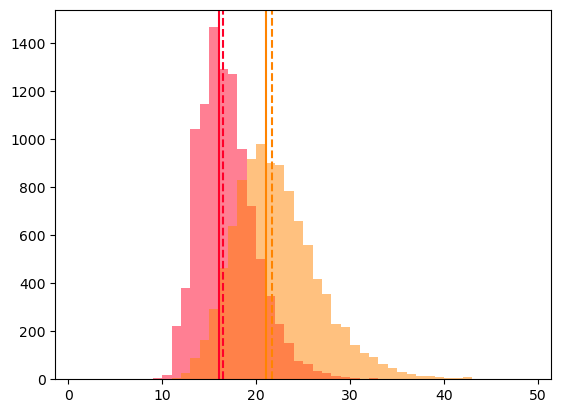

In [7]:
#################### PARAMETERS #########################
# Set player epsilons (0 vs 1 is arbitrary)
e0 = 2
e1 = 1

# Set starting states
starting_score0 = 501 
starting_score1 = 501
starting_credits0 = 0 
starting_credits1 = 0

# Can override iterations here if desired
iterations = default_iterations 

########################################################

# Initialize color scheme
vmax=max(epsilon_list)
vmin=min(epsilon_list)

# Initialize simulators
sim0 = Simulator(epsilon=e0,player_num=player_id)
sim1 = Simulator(epsilon=e1,player_num=player_id)

# Run simulation and collect data
data0 = [len(x)-1 for x in sim0.run_simulation(iterations,starting_score=starting_score0,starting_credits=starting_credits0)]
data1 = [len(x)-1 for x in sim1.run_simulation(iterations,starting_score=starting_score1,starting_credits=starting_credits1)]

# Get colors for each epsilon value
color0 = color_map_color(e0, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
color1 = color_map_color(e1, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
# color1 = 'grey' # can uncomment this if two chosen colors are too similar


# Plot e1
plt.hist(np.array(data1),color=color1,alpha=0.5,bins=list(range(1,50))) # histogram
plt.axvline(statistics.mean(data1),color=color1,linestyle='dashed') # mean 
plt.axvline(statistics.median(data1),color=color1) # median

# Plot e0
plt.hist(np.array(data0),color=color0,alpha=0.5,bins=list(range(1,50))) # histogram
plt.axvline(statistics.mean(data0),color=color0,linestyle='dashed') # mean
plt.axvline(statistics.median(data0),color=color0) # median



# 5.0 Single Distribution Plot for Different Epsilons

Examine how simulated outcome distribution varies with epsilon.

In [8]:
# Run simulations for single player with different epsilon values (will take over a minute to run for 10k iterations)

#################### PARAMETERS #########################
# Can override the defaults above if desired
iterations = default_iterations
player_num = player_id

# Set the starting state of the game 
starting_score = 501
starting_credits = 0
#########################################################

# Initialize the dataframe
col_names = ['player','epsilon','tokens','game_id','throw_number','state','state_score','state_tokens']
df = pd.DataFrame(columns=col_names)

# Iterate through epsilons
for epsilon in epsilon_list:
    # Initialize the simulator
    sim = Simulator(player_num=player_num,epsilon=epsilon)
    # Run the simulation
    simulation_paths = sim.run_simulation(iterations, starting_score=starting_score, starting_credits=starting_credits)
    # Append to the dataframe 
    df = pd.concat([df,build_dataset(simulation_paths,player_num,epsilon,starting_credits)])
    df = df.reset_index().drop(['index'],axis=1)
    


load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl


Ran in 4.638s.
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e2_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 6.529s.
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e3_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 7.804s.
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e4_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 8.804s.
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e5_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tok

In [9]:
# Generate dataset (will take about 20s to run for 10k iterations) 

df_sim = df.groupby(['epsilon','tokens','game_id']).max().throw_number.reset_index()
df_sim.columns = ['epsilon','credits','game','throws']
df_sim = df_sim[['epsilon','credits','throws']]



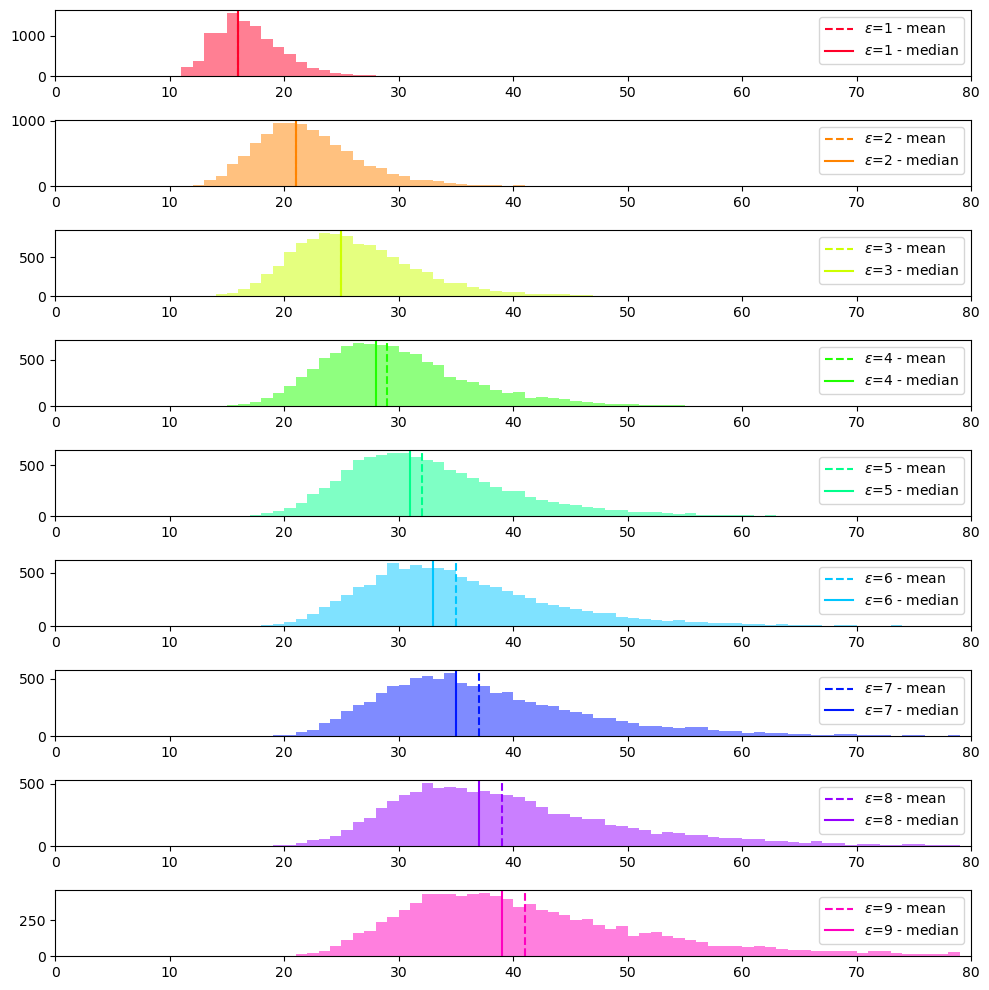

In [10]:
# Plot dataset 

xmin=0
xmax=80

fig, ax = plt.subplots(9, figsize=(10,10))

vmax=max(epsilon_list)
vmin=min(epsilon_list)

handicap_list = ['spot_point_heuristic','spot_point_optimal','dynamic_credits']

row = 0 

for e1 in epsilon_list:

    # Extract data and colors 
    data1 = df_sim.loc[df_sim.epsilon==e1].throws.values
    color1 = color_map_color(e1, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)

    # Plot baseline 
    ax[row].hist(np.array(data1),color=color1,alpha=0.5,bins=list(range(1,80)))
    ax[row].axvline(statistics.mean(data1),color=color1,linestyle='dashed')
    ax[row].axvline(statistics.median(data1),color=color1)
        
    ax[row].set_xlim((xmin,xmax))

    ax[row].legend([f'$\epsilon$={e1} - mean',f'$\epsilon$={e1} - median'])

    row = row + 1 


fig.tight_layout()

# 6.0 Handicap Distribution Comparison Plots

Explore how different handicaps perform from a distribution perspective for different epsilon match-ups.

In [11]:
# Generate Dataset 

##################### PARAMETERS ######################
# Can override default if desired 
iterations = 1000 # default_iterations

#######################################################

# Placeholder for simulation paths 
sim_paths = {}

# Run simulations for all handicaps 
for e1 in epsilon_list:

    sim_paths[e1] = {}

    # Baseline 
    sim1 = Simulator(player_num=player_id,epsilon=e1)
    sim_paths[e1]['baseline'] = sim1.run_simulation(iterations,starting_score=501,starting_credits=0)

    for e0 in epsilon_list:
        
        if e1 <= e0:

            sim0 = Simulator(player_num=player_id,epsilon=e0)

            sim_paths[e1][e0] = {}

            spot_points_heuristic = handicap.get_spot_point_heuristic_handicap(e1,e0)
            spot_points_optimal = handicap.get_spot_point_optimal_handicap(e1,e0)
            credits, credits_lower, credits_higher, threshold_higher_multiplier = handicap.get_dynamic_credits_handicap_full(e1,e0)
            threshold_higher = int(round(iterations * threshold_higher_multiplier))

            sim_paths[e1][e0]['spot_point_heuristic'] = sim0.run_simulation(iterations,starting_score=501,starting_credits=0,spot_points=spot_points_heuristic)
            sim_paths[e1][e0]['spot_point_optimal'] = sim0.run_simulation(iterations,starting_score=501,starting_credits=0,spot_points=spot_points_optimal)
            sim_paths[e1][e0]['dynamic_credits'] = sim0.run_simulation(threshold_higher,starting_score=501,starting_credits=credits_higher)
            sim_paths[e1][e0]['dynamic_credits'].extend(sim0.run_simulation(iterations-threshold_higher,starting_score=501,starting_credits=credits_lower))
            

load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 0.500s.
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 0.521s.
Ran in 0.509s.
Ran in 0.000s.
Ran in 0.505s.
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e2_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 0.494s.
Ran in 0.469s.
Ran in 0.038s.
Ran in 0.432s.
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e3_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_par

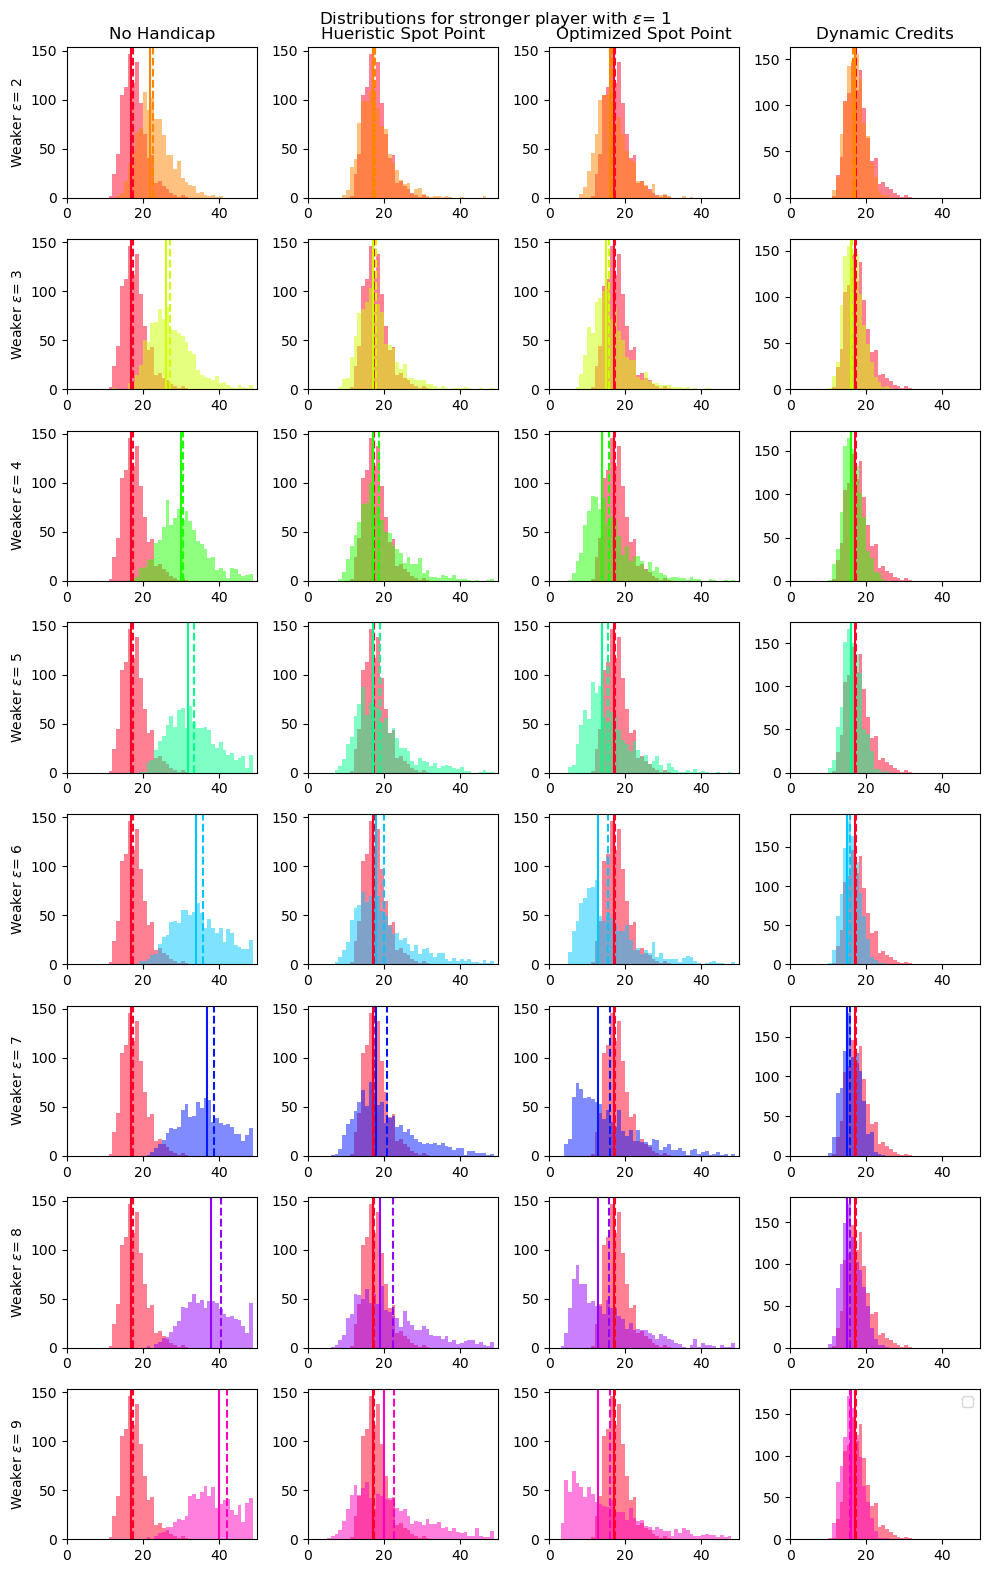

In [12]:
# Plotting sandbox 

########################## PARAMETERS ###################################

stronger_e = 1

#########################################################################

xmin = 0
xmax = 50
num_rows = len(epsilon_list) - stronger_e

fig, ax = plt.subplots(num_rows, 4, figsize=(10,num_rows*2))

sim_lengths = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)

handicap_list = ['spot_point_heuristic','spot_point_optimal','dynamic_credits']

row = 0 

for e1 in [stronger_e]:

    for e0 in epsilon_list:
        
        if e1 < e0:

            #print(f'Completed for {e1} and {e0}')

            # Extract data and colors 
            data1 = [len(x) for x in sim_paths[e1]['baseline']]
            data0 = [len(x) for x in sim_paths[e0]['baseline']]
            color1 = color_map_color(e1, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
            color0 = color_map_color(e0, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)

            # Plot baseline 
            ax[row,0].hist(np.array(data1),color=color1,alpha=0.5,bins=list(range(xmin,xmax)))
            ax[row,0].axvline(statistics.mean(data1),color=color1,linestyle='dashed')
            ax[row,0].axvline(statistics.median(data1),color=color1)
            ax[row,0].hist(np.array(data0),color=color0,alpha=0.5,bins=list(range(xmin,xmax)))
            ax[row,0].axvline(statistics.mean(data0),color=color0,linestyle='dashed')
            ax[row,0].axvline(statistics.median(data0),color=color0)
             
            ax[row,0].set_xlim((xmin,xmax))
            ax[row,0].set_ylabel(f'Weaker $\epsilon$= {e0}')  

            plt.legend([f'{e1} - mean',f'{e1} - median',f'{e0} - mean',f'{e0} - median'])
            
            # Plot handicaps 

            for j in range(len(handicap_list)):

                data0 = [len(x) for x in sim_paths[e1][e0][handicap_list[j]]]
                col = j+1 

                ax[row,col].hist(np.array(data1),color=color1,alpha=0.5,bins=list(range(xmin,xmax)))
                ax[row,col].axvline(statistics.mean(data1),color=color1,linestyle='dashed')
                ax[row,col].axvline(statistics.median(data1),color=color1)
                ax[row,col].hist(np.array(data0),color=color0,alpha=0.5,bins=list(range(xmin,xmax)))
                ax[row,col].axvline(statistics.mean(data0),color=color0,linestyle='dashed')
                ax[row,col].axvline(statistics.median(data0),color=color0)
                
                ax[row,col].set_xlim((xmin,xmax))
                

            row = row + 1 

fig.suptitle(f"Distributions for stronger player with $\epsilon$= {e1}")
ax[0,0].title.set_text('No Handicap')
ax[0,1].title.set_text('Hueristic Spot Point')
ax[0,2].title.set_text('Optimized Spot Point')
ax[0,3].title.set_text('Dynamic Credits')
fig.tight_layout()



# 7.0 Evaluating Win Probabilities 

## 7.1 Spot Point Heuristic

In [13]:
## Run Simulation 

########################## PARAMETERS ###################################

iterations = 1000 #  default_iterations
starting_score = 501

#########################################################################

tokens1 = 0
tokens0 = 0

spot_points1=0
spot_points0=0

spot_darts1=0
spot_darts0=0

outcomes_sp_baseline = []


for epsilon1 in epsilon_list:
    
    for epsilon0 in epsilon_list:

        if epsilon1<=epsilon0:

            spot_points0 = handicap.get_spot_point_heuristic_handicap(epsilon1,epsilon0)

            # Initialize simulators
            sim0 = Simulator(epsilon=epsilon0,player_num=player_id)
            sim1 = Simulator(epsilon=epsilon1,player_num=player_id)

            # Run simulation and collect data
            sim0_paths = sim0.run_simulation(iterations,starting_score=starting_score,starting_credits=0,spot_points=spot_points0)
            sim1_paths = sim1.run_simulation(iterations,starting_score=starting_score,starting_credits=0)
        
            starter = 0 

            for iter in range(iterations):

                # get the number of throwws 
                turn_path1 = sim1_paths[iter]
                turn_path0 = sim0_paths[iter]
                turns1 = len(turn_path1)
                turns0 = len(turn_path0)

                # declare the winner 
                if turns1 < turns0: 
                    winner = 1
                elif turns1 > turns0:
                    winner = 0
                elif turns1 == turns0:
                    winner = starter 
                
                # update starter so that they take turns
                if starter == 1:
                    starter = 0
                else:
                    starter =1 
                
                outcomes_sp_baseline.append([player_num,epsilon1,epsilon0,tokens1,tokens0,spot_points1,spot_points0,spot_darts1,spot_darts0,iter,winner])



load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 0.494s.
Ran in 0.499s.
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e2_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 0.506s.
Ran in 

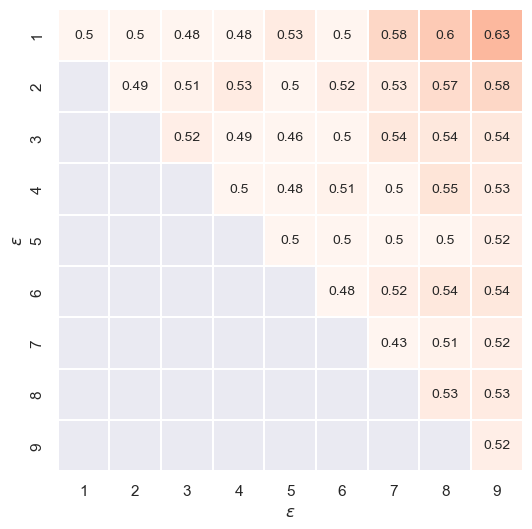

In [14]:
# Plot results 

# Shape into a dataframe
col_names = ['player','epsilon_strong','epsilon_weak','tokens_strong','tokens_weak','spot_points_strong','spot_points_weak','spot_darts_strong','spot_darts_weak','game_id','winner_strong']
df_sp_baseline_results = pd.DataFrame(data=outcomes_sp_baseline,columns=col_names)

# Reformat dataframe
df_sp_baseline_results = df_sp_baseline_results.groupby(['epsilon_strong','epsilon_weak']).mean('winner_strong')['winner_strong'].reset_index()
df_sp_baseline_results = df_sp_baseline_results.round(2)

# Create desired graph structure
df_sp_baseline_results_graph = df_sp_baseline_results.pivot(columns='epsilon_weak',index='epsilon_strong',values='winner_strong')

# Plot 
fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(df_sp_baseline_results_graph,annot=True,annot_kws={"size": 10},fmt="",cmap='Reds',linewidths=0.30,cbar=False,vmin=0.5,vmax=1)
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

## 7.2 Optimized Spot Point

In [15]:
## Run Simulation 

########################## PARAMETERS ###################################

iterations = default_iterations
starting_score = 501

#########################################################################

tokens1 = 0
tokens0 = 0

spot_points1=0
spot_points0=0

spot_darts1=0
spot_darts0=0

outcomes_sp_optimized = []


for epsilon1 in epsilon_list:
    
    for epsilon0 in epsilon_list:

        if epsilon1<=epsilon0:

            spot_points0 = handicap.get_spot_point_optimal_handicap(epsilon1,epsilon0)

            # Initialize simulators
            sim0 = Simulator(epsilon=epsilon0,player_num=player_id)
            sim1 = Simulator(epsilon=epsilon1,player_num=player_id)

            # Run simulation and collect data
            sim0_paths = sim0.run_simulation(iterations,starting_score=starting_score,starting_credits=0,spot_points=spot_points0)
            sim1_paths = sim1.run_simulation(iterations,starting_score=starting_score,starting_credits=0)
        
        
            starter = 0 

            for iter in range(iterations):

                # get the number of throwws 
                turn_path1 = sim1_paths[iter]
                turn_path0 = sim0_paths[iter]
                turns1 = len(turn_path1)
                turns0 = len(turn_path0)

                # declare the winner 
                if turns1 < turns0: 
                    winner = 1
                elif turns1 > turns0:
                    winner = 0
                elif turns1 == turns0:
                    winner = starter 
                
                # update starter so that they take turns
                if starter == 1:
                    starter = 0
                else:
                    starter =1 
                
                outcomes_sp_optimized.append([player_num,epsilon1,epsilon0,tokens1,tokens0,spot_points1,spot_points0,spot_darts1,spot_darts0,iter,winner])



load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 4.733s.
Ran in 4.620s.
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e2_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 4.352s.
Ran in 

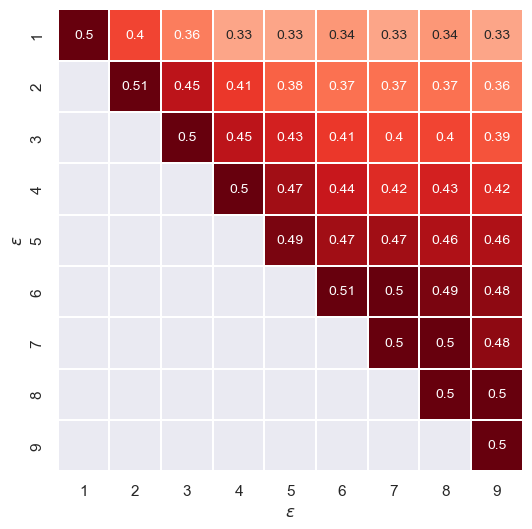

In [16]:
# Plot 

# Create dataframe
col_names = ['player','epsilon_strong','epsilon_weak','tokens_strong','tokens_weak','spot_points_strong','spot_points_weak','spot_darts_strong','spot_darts_weak','game_id','winner_strong']
df_sp_optimized_results = pd.DataFrame(data=outcomes_sp_optimized,columns=col_names)

# Reformat dataframe
df_sp_optimized_results = df_sp_optimized_results.groupby(['epsilon_strong','epsilon_weak']).mean('winner_strong')['winner_strong'].reset_index()
df_sp_optimized_results = df_sp_optimized_results.round(2)

# Tranform to desired shape for graph
df_sp_optimized_results_graph = df_sp_optimized_results.pivot(columns='epsilon_weak',index='epsilon_strong',values='winner_strong')

# Plot 
fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(df_sp_optimized_results_graph,annot=True,annot_kws={"size": 10},fmt="",cmap='Reds',linewidths=0.30,cbar=False,vmin=0.25,vmax=0.5)
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

## 7.3 Dynamic Credits

In [17]:
## Run Simulation 

########################## PARAMETERS ###################################

iterations = default_iterations
starting_score = 501

#########################################################################

tokens1 = 0
tokens0 = 0

spot_points1=0
spot_points0=0

spot_darts1=0
spot_darts0=0

outcomes_dynamic_credits = []


for epsilon1 in epsilon_list:
    
    for epsilon0 in epsilon_list:

        if epsilon1<=epsilon0:

            credits, credits_lower, credits_higher, threshold_higher_multiplier = handicap.get_dynamic_credits_handicap_full(epsilon1,epsilon0)
            threshold_higher = int(round(iterations * threshold_higher_multiplier))

            # Initialize simulators
            sim0 = Simulator(epsilon=epsilon0,player_num=player_id)
            sim1 = Simulator(epsilon=epsilon1,player_num=player_id)

            # Run simulation and collect data
            sim0_paths = sim0.run_simulation(threshold_higher,starting_score=starting_score,starting_credits=credits_higher)
            sim0_paths.extend(rum_simulation(iterations-threshold_higher,starting_score=starting_score,starting_credits=credits_lower))
            sim1_paths = sim1.run_simulation(iterations,starting_score=starting_score,starting_credits=0)

            starter = 0 

            for iter in range(iterations):

                # get the number of throwws 
                turn_path1 = sim1_paths[iter]
                turn_path0 = sim0_paths[iter]
                turns1 = len(turn_path1)
                turns0 = len(turn_path0)

                # declare the winner 
                if turns1 < turns0: 
                    winner = 1
                elif turns1 > turns0:
                    winner = 0
                elif turns1 == turns0:
                    winner = starter 
                
                # update starter so that they take turns
                if starter == 1:
                    starter = 0
                else:
                    starter =1 
                
                outcomes_dynamic_credits.append([player_num,epsilon1,epsilon0,tokens1,tokens0,spot_points1,spot_points0,spot_darts1,spot_darts0,iter,winner])



load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/playerAVG_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 0.000s.


NameError: name 'rum_simulation' is not defined

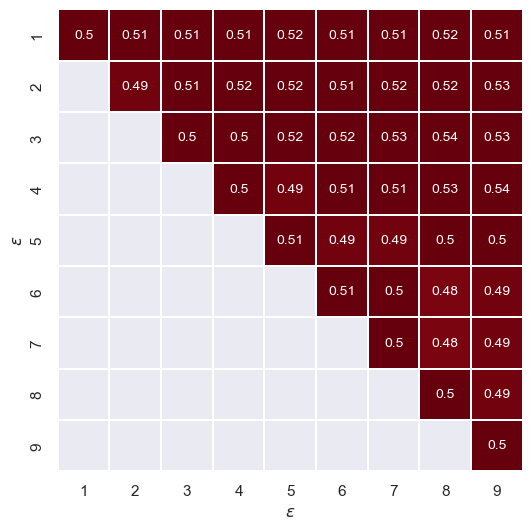

In [ ]:
col_names = ['player','epsilon_strong','epsilon_weak','tokens_strong','tokens_weak','spot_points_strong','spot_points_weak','spot_darts_strong','spot_darts_weak','game_id','winner_strong']
df_dynamic_credits_results = pd.DataFrame(data=outcomes_dynamic_credits,columns=col_names)

df_dynamic_credits_results = df_dynamic_credits_results.groupby(['epsilon_strong','epsilon_weak']).mean('winner_strong')['winner_strong'].reset_index()
df_dynamic_credits_results = df_dynamic_credits_results.round(2)

df_dynamic_credits_results_graph = df_dynamic_credits_results.pivot(columns='epsilon_weak',index='epsilon_strong',values='winner_strong')

fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(df_dynamic_credits_results_graph,annot=True,annot_kws={"size": 10},fmt="",cmap='Reds',linewidths=0.30,cbar=False,vmin=0.5,vmax=1)
#fig = plt.title("Difference in expected throws using spot point handicap system")
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

# 8.0 Appendix: Distribuiton Fitting

This analysis was not used and has not been fully cleaned up but is here for reference. The goal was to see if the relationship between $\epsilon$,$\beta$ and game outcomes could be described as a parameterized probability distribution.

In [ ]:
#!pip install fitter

from fitter import Fitter, get_common_distributions, get_distributions

import function_tool as ft 

In [ ]:

########################## PARAMETERS ###################################

iterations = default_iterations
starting_score = 501
beta_list = [0,1,2,3,4,5,6,7,8,9]

#########################################################################

dist_paths = {}
beta_list = list(range(10))

for epsilon in epsilon_list:

    dist_paths[epsilon] = {}

    sim = Simulator(epsilon=epsilon,player_num=player_id)

    for beta in beta_list: 

        dist_paths[epsilon][beta] = sim.run_simulation(iterations,starting_score=501,starting_credits=beta)

        print(f'Loop completed for epsilon={epsilon} and beta={beta}.')


load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaussin_prob_grid_custom_tokens.pkl
Ran in 0.048s.
Loop completed for epsilon=1 and beta=0.
Ran in 0.047s.
Loop completed for epsilon=1 and beta=1.
Ran in 0.045s.
Loop completed for epsilon=1 and beta=2.
Ran in 0.047s.
Loop completed for epsilon=1 and beta=3.
Ran in 0.046s.
Loop completed for epsilon=1 and beta=4.
Ran in 0.047s.
Loop completed for epsilon=1 and beta=5.
Ran in 0.048s.
Loop completed for epsilon=1 and beta=6.
Ran in 0.045s.
Loop completed for epsilon=1 and beta=7.
Ran in 0.045s.
Loop completed for epsilon=1 and beta=8.
Ran in 0.047s.
Loop completed for epsilon=1 and beta=9.
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e2_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_tokens/t_gaus

In [ ]:
# Save results to pickle so don't need to rerun every time (takes ~1 hour for 10,000 iterations)
ft.dump_pickle('result/singlegame_simulation_results/distribution_paths_noturn.pkl', dist_paths)


Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 15.38it/s]


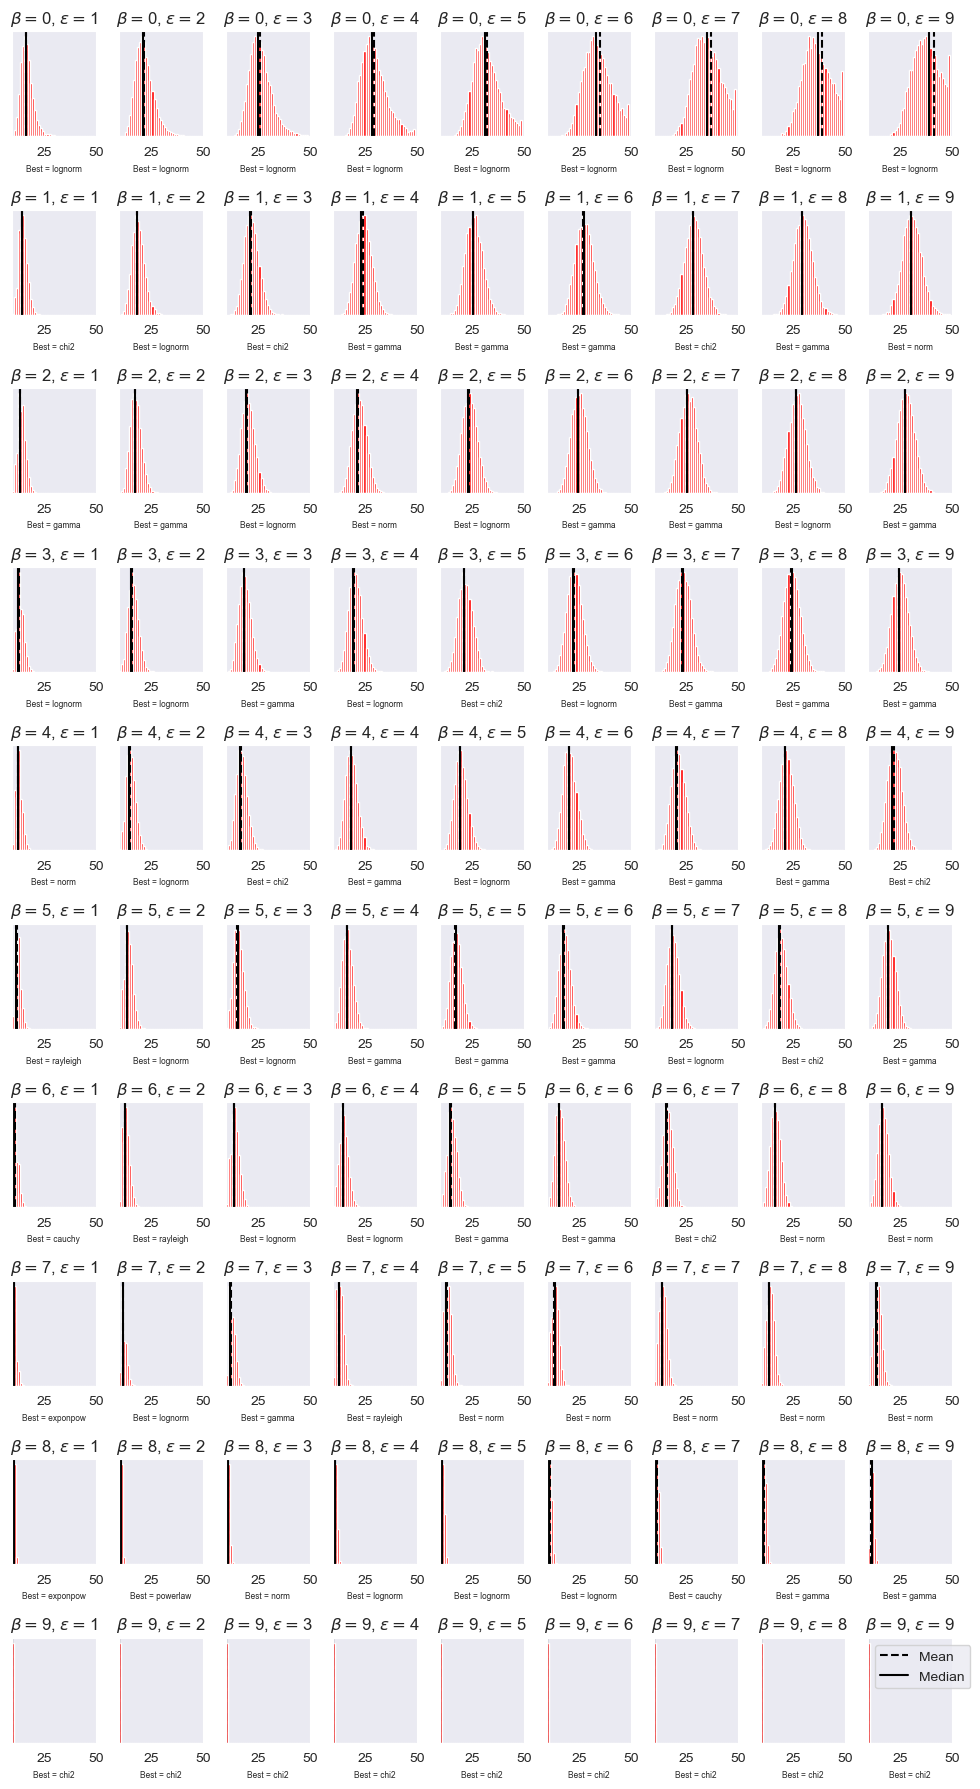

In [ ]:
dist_paths = ft.load_pickle('result/singlegame_simulation_results/distribution_paths_noturn.pkl')

sns.set_style("dark")
#sns.set_style("ticks")

xmin = 9
xmax = 50
num_rows = len(epsilon_list) 

fig, ax = plt.subplots(len(beta_list), len(epsilon_list), figsize=(10,num_rows*2))

sim_lengths = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)

handicap_list = ['spot_point_heuristic','spot_point_optimal','dynamic_credits']

row = 0 

for epsilon_index in range(len(epsilon_list)):

    epsilon = epsilon_list[epsilon_index]

    for beta in beta_list:
        
            data1 = [len(x)-1 for x in dist_paths[epsilon][beta]]
            #color1 = color_map_color(e1, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
            color1='red'

            # Plot baseline 
            ax[beta,epsilon_index].hist(np.array(data1),color='red',bins=list(range(9,50)))
            ax[beta,epsilon_index].axvline(statistics.mean(data1),color='black',linestyle='dashed')
            ax[beta,epsilon_index].axvline(statistics.median(data1),color='black')

            f = Fitter(data1,distributions=get_common_distributions())
            f.fit()
            name = list(f.get_best().keys())[0]

            ax[beta,epsilon_index].set_xlim((xmin,xmax))
            ax[beta,epsilon_index].title.set_text(fr'$\beta=${beta}, $\epsilon=${epsilon}')
            ax[beta,epsilon_index].set_xlabel(f'Best = {name}',fontsize=6)
            ax[beta,epsilon_index].set_yticklabels([])

            plt.legend([f'Mean','Median'])


fig.tight_layout()

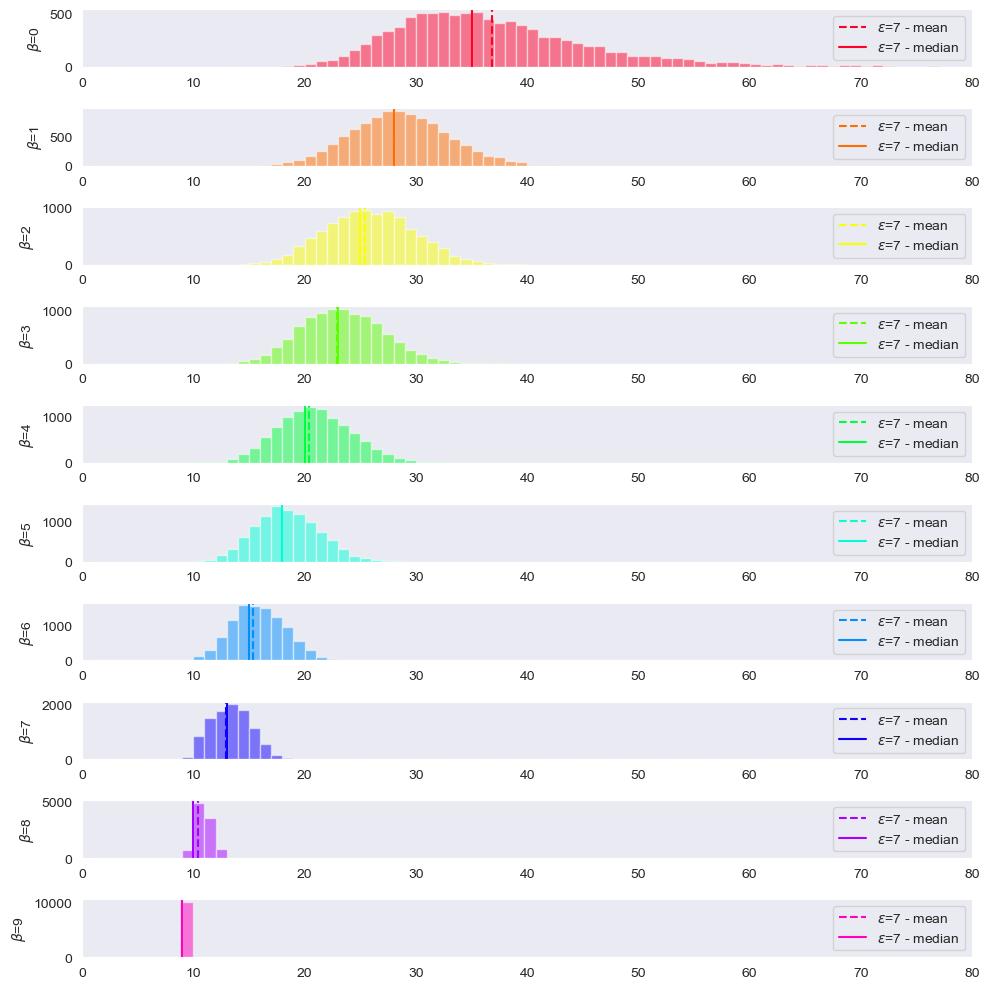

In [ ]:
xmin=0
xmax=80

fig, ax = plt.subplots(10, figsize=(10,10))

vmax=max(beta_list)
vmin=min(beta_list)

handicap_list = ['spot_point_heuristic','spot_point_optimal','dynamic_credits']

row = 0 

e1=7

for beta in beta_list:

    # Extract data and colors 
    data1 = [len(x)-1 for x in dist_paths[e1][beta] ]
    color1 = color_map_color(beta, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)

    # Plot baseline 
    ax[row].hist(np.array(data1),color=color1,alpha=0.5,bins=list(range(1,80)))
    ax[row].axvline(statistics.mean(data1),color=color1,linestyle='dashed')
    ax[row].axvline(statistics.median(data1),color=color1)
    ax[row].set_ylabel(fr'$\beta$={beta}')
    ax[row].set_xlim((xmin,xmax))

    ax[row].legend([f'$\epsilon$={e1} - mean',f'$\epsilon$={e1} - median'])

    row = row + 1 

fig.tight_layout()

/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_66553/3668338385.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data1, hist=True, kde=True,


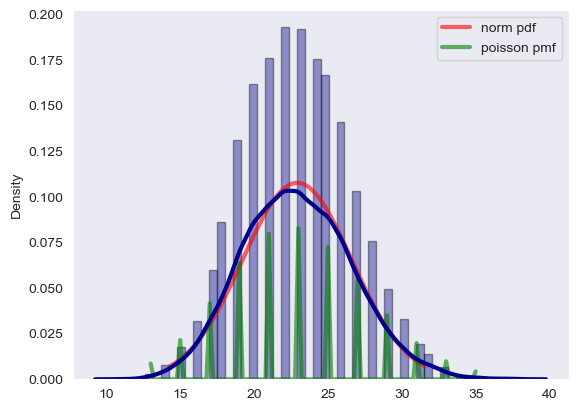

In [ ]:
e1=7
beta=3
data1 = [len(x)-1 for x in dist_paths[e1][beta] ]
# f = Fitter(data1,distributions=['norm','lognrom','gamma'])
# f.fit()
# #name = list(f.get_best().keys())[0]
# print(f.get_best())

# f.summary()

from scipy.stats import norm, lognorm, gamma, poisson

norm_params = norm.fit(data1)

fig, ax = plt.subplots(1, 1)
rv = norm.rvs(loc=norm_params[0],scale=norm_params[1])
x = np.linspace(norm.ppf(0.01,loc=norm_params[0],scale=norm_params[1]),
                norm.ppf(0.99,loc=norm_params[0],scale=norm_params[1]), 100)
y = np.linspace(poisson.ppf(0.01,mu=norm_params[0]),
                poisson.ppf(0.99,mu=norm_params[0]), 100)
ax.plot(x, norm.pdf(x,loc=norm_params[0],scale=norm_params[1]),
       'r-', lw=3, alpha=0.6, label='norm pdf')
ax.plot(y, poisson.pmf(y,mu=norm_params[0]),
       'green', lw=3, alpha=0.6, label='poisson pmf')

sns.distplot(data1, hist=True, kde=True, 
             #bins=int(180/5),
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3},ax=ax)

plt.legend()

In [ ]:
for epsilon_index in range(len(epsilon_list)):

    epsilon = epsilon_list[epsilon_index]

    for beta in beta_list:
        
            data1 = [len(x)-1 for x in dist_paths[epsilon][beta]]

            f = Fitter(data1,distributions=['lognorm'])#get_common_distributions())
            f.fit()
            name = list(f.get_best().keys())[0]
            p_s = round(f.get_best()['lognorm']['s'],2)
            p_loc = round(f.get_best()['lognorm']['loc'],2)
            p_scale = round(f.get_best()['lognorm']['scale'],2)

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


In [ ]:
from scipy.stats import kstest

beta=0

for epsilon in epsilon_list:

    data1=[len(x)-1 for x in dist_paths[epsilon][beta]]

    lognorm_params = lognorm.fit(data1)

    x = np.linspace(lognorm.ppf(0.01,s=lognorm_params[0],loc=lognorm_params[1],scale=lognorm_params[2]),
                    lognorm.ppf(0.99,s=lognorm_params[0],loc=lognorm_params[1],scale=lognorm_params[2]), 100)

    print(epsilon,kstest(data1,lognorm.cdf(x,s=lognorm_params[0],loc=lognorm_params[1],scale=lognorm_params[2])))


1 KstestResult(statistic=1.0, pvalue=1.1283555904379908e-242)
2 KstestResult(statistic=1.0, pvalue=1.1283555904379908e-242)
3 KstestResult(statistic=1.0, pvalue=1.1283555904379908e-242)
4 KstestResult(statistic=1.0, pvalue=1.1283555904379908e-242)
5 KstestResult(statistic=1.0, pvalue=1.1283555904379908e-242)
6 KstestResult(statistic=1.0, pvalue=1.1283555904379908e-242)
7 KstestResult(statistic=1.0, pvalue=1.1283555904379908e-242)
8 KstestResult(statistic=1.0, pvalue=1.1283555904379908e-242)
9 KstestResult(statistic=1.0, pvalue=1.1283555904379908e-242)
